In [1]:
import numpy as np
import cv2
import glob
import time
import pickle
from collections import deque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
# from sklearn.cross_validation import train_test_split  # for scikit-learn version <= 0.17
from sklearn.model_selection import train_test_split  # if you are using scikit-learn >= 0.18
from scipy.ndimage.measurements import label

## 1 - Feature extraction functions

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img,
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Change image color space
def change_colorspace(img, color_space = 'RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        conv_image = np.copy(img)
    
    return conv_image


# Extract features from a single image
def extract_features_from_image(img,
                                color_space='RGB',
                                spatial_size=(32, 32),
                                hist_bins=32,
                                orient=9, 
                                pix_per_cell=8,
                                cell_per_block=2,
                                hog_channel='ALL'):
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
        
    #3) Compute spatial features if flag is set
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    
    #4) Append features to list
    img_features.append(spatial_features)
    
    #5) Compute histogram features if flag is set
    hist_features = color_hist(feature_image, nbins=hist_bins)
    
    #6) Append features to list
    img_features.append(hist_features)
    
    #7) Compute HOG features if flag is set
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.array(hog_features)
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
    #8) Append features to list
    img_features.append(hog_features)
    
    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Extract features from a list of images
def extract_features_from_image_list(img_file_list,
                                     color_space='RGB',
                                     spatial_size=(32, 32),
                                     hist_bins=32,
                                     orient=9,
                                     pix_per_cell=8,
                                     cell_per_block=2,
                                     hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for img_file in img_file_list:      
        # Read in each one by one
        img = mpimg.imread(img_file)
        # Extract features from each of them
        img_features = extract_features_from_image(img,
                                                   color_space=color_space,
                                                   spatial_size=spatial_size,
                                                   hist_bins=hist_bins,
                                                   orient=orient, 
                                                   pix_per_cell=pix_per_cell,
                                                   cell_per_block=cell_per_block,
                                                   hog_channel=hog_channel)
        
        features.append(img_features)
        
    # Return list of feature vectors
    return features

## 2 - Object detection functions

In [8]:
class VehicleDetector():
    def __init__(self,
                 classifier,
                 scaler,
                 color_space='YCrCb',              # Color space used for all features
                 hog_channel='ALL',                # Image channels on which we want to compute HOG
                 hog_orient=11,                    # HOG possible orientations
                 hog_pix_per_cell=16,              # HOG number of px per cell
                 hog_cell_per_block=2,             # HOG number of cells per block
                 spatial_size=(32,32),             # SPATIAL features resize
                 histogram_bins=32,                # HISTOGRAM number of bins
                 show_intermediate_results=False):
        
        self.classifier = classifier
        self.scaler = scaler
        self.color_space = color_space
        self.hog_channel = hog_channel
        self.hog_orient = hog_orient
        self.hog_pix_per_cell = hog_pix_per_cell
        self.hog_cell_per_block = hog_cell_per_block
        self.spatial_size = spatial_size
        self.histogram_bins = histogram_bins
        self.show_intermediate_results = show_intermediate_results
        self.show_intermediate_video = False
        
        self.search_settings = (((400, 400+64+64), 1.0),
                                ((380, 380+96+64), 1.5),
                                ((400, 400+128+64), 2.0),
                                ((440, 440+700), 2.5))
        
        # Best heatmap
        self.heatmap = None
        
        # Heatmaps FIFO length
        self.heatmap_fifo_length = 4
        
        # Heatmaps FIFO
        self.heatmap_fifo = deque(maxlen=self.heatmap_fifo_length)
        
        # Centroid FIFO (list of lists)
        self.centroid_fifo = deque(maxlen=self.heatmap_fifo_length)
        
        # Frame counter
        self.frame_count = 0
        self.full_frame_processing_every = 10
        
        # The left boundary of the window search
        self.xstart = 63
        
        # Mask dilation kernel size
        self.mask_dilation_kernel = np.ones((50, 50))
        
        # Gaussian blur kernel size
        self.blur_kernel = 3
        
        # Threshold for heatmap
        self.threshold = 2
        
        
    def search_in_image(self, img):
        
        # Create an empty list to receive positive detection windows
        on_windows = []
        
        draw_img = np.copy(img)
        img = img.astype(np.float32) / 255
        
        # Mask on what portion of the image we shall work        
        if self.frame_count % self.full_frame_processing_every == 0:
            mask = np.ones_like(img[:, :, 0])
        else:
            # f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
            mask = np.sum(np.array(self.heatmap_fifo), axis=0)
            mask[(mask > 0)] = 1
            # ax1.imshow(mask)
            # Check if mask is all dark, in this case it doesn't make sense to have a mask
            if np.sum(mask) == 0:
                mask = np.ones_like(img[:, :, 0])
            else:
                mask = cv2.dilate(mask, self.mask_dilation_kernel, iterations=3)
            # ax2.imshow(mask)
            
        # Increment frame counter
        self.frame_count += 1
        
        # Run the search for each setting combination
        for ((ystart, ystop), scale) in self.search_settings:
            
            # Determine the boundaries of the area we want to search
            nonzero = mask.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            if len(nonzeroy) != 0:
                ystart = max(np.min(nonzeroy), ystart)
                ystop = min(np.max(nonzeroy), ystop)
            if len(nonzeroy) != 0:
                xstart = max(np.min(nonzerox), self.xstart)
                xstop = np.max(nonzerox)
            else:
                continue
                
            if xstop <= xstart or ystop <= ystart:
                continue
                
            # Isolate the portion of image we want to work on
            img_tosearch = img[ystart:ystop, xstart:xstop, :]
            
            # Change colorspace as specified
            ctrans_tosearch = change_colorspace(img_tosearch, color_space=self.color_space)
            
            # Scale image as specified
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ys = np.int(imshape[1] / scale)
                xs = np.int(imshape[0] / scale)
                if (ys < 1 or xs < 1):
                    continue
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

            if ctrans_tosearch.shape[0] < 64 or ctrans_tosearch.shape[1] < 64:
                continue
                
            # Separate channels
            if hog_channel == 'ALL':
                ch1 = ctrans_tosearch[:,:,0]
                ch2 = ctrans_tosearch[:,:,1]
                ch3 = ctrans_tosearch[:,:,2]
            else:
                ch1 = ctrans_tosearch[:,:,self.hog_channel]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // self.hog_pix_per_cell) - 1
            nyblocks = (ch1.shape[0] // self.hog_pix_per_cell) - 1
            nfeat_per_block = self.hog_orient * self.hog_cell_per_block ** 2
            
            # 64 was the original sampling rate, with 8 cells and 8 pix per cell
            window_size = 64
            nblocks_per_window = (window_size // self.hog_pix_per_cell) -1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step

            # Compute HOG features over the whole image
            if hog_channel == 'ALL':
                hog1 = get_hog_features(ch1, hog_orient, hog_pix_per_cell, hog_cell_per_block, feature_vec=False)
                hog2 = get_hog_features(ch2, hog_orient, hog_pix_per_cell, hog_cell_per_block, feature_vec=False)
                hog3 = get_hog_features(ch3, hog_orient, hog_pix_per_cell, hog_cell_per_block, feature_vec=False)
            else:
                hog1 = get_hog_features(ch1, hog_orient, hog_pix_per_cell, hog_cell_per_block, feature_vec=False)
            
            # Iterate over all windows in the list
            for xb in range(nxsteps + 1):
                for yb in range(nysteps + 1):

                    ypos = yb * cells_per_step
                    xpos = xb * cells_per_step

                    # Extract HOG for this patch
                    if hog_channel == 'ALL':
                        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                        hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                        hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                    else:
                        hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

                    xleft = xpos * self.hog_pix_per_cell
                    ytop = ypos * self.hog_pix_per_cell
                    
                    # Extract the image patch
                    subimg = ctrans_tosearch[ytop:ytop + window_size, xleft:xleft + window_size]

                    # Spatial features
                    spatial_features = bin_spatial(subimg, size=spatial_size)

                    # Histogram features
                    hist_features = color_hist(subimg, nbins=histogram_bins)

                    # Stack all features
                    features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)

                    # Scale extracted features to be fed to classifier
                    scaled_features = self.scaler.transform(features)

                    # Predict using your classifier
                    prediction = self.classifier.predict(scaled_features)

                    # If positive (prediction == 1) then save the window
                    show_all_windows = 0
                    if prediction == 1 or show_all_windows:
                        xbox_left = xstart + np.int(xleft * scale)
                        xbox_right = xbox_left + np.int(window_size * scale)
                        ybox_top = ystart + np.int(ytop * scale)
                        ybox_bottom = ybox_top + np.int(window_size * scale)
                        on_windows.append(((xbox_left, ybox_top),(xbox_right, ybox_bottom)))
        
        
        # Compute heatmap and update internal status
        self.generate_heatmap(draw_img, on_windows, self.threshold)
        
        #self.generate_heatmap2(draw_img, on_windows, self.threshold)
        
        # Find final boxes from heatmap using label function
        labels = label(self.heatmap)
        VehicleDetector.draw_labeled_bboxes(draw_img, labels)
        
        if self.show_intermediate_results:
            f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
            
            on_windows_img = draw_boxes(draw_img, on_windows)
            ax1.imshow(on_windows_img)
            ax1.set_title('Positive detections')
            
            ax2.imshow(self.heatmap, cmap='hot')
            ax2.set_title('Heatmap (based on the last {} frames)'.format(self.heatmap_fifo_length))
            
            ax3.imshow(draw_img)
            ax3.set_title('Final boxes')
            
        """
            heatmap_img = np.dstack((self.heatmap, self.heatmap, self.heatmap))
            
            little_img = cv2.resize(heatmap_img, None,
                                    fx=0.25, fy=0.25,
                                    interpolation = cv2.INTER_CUBIC)
            
            draw_img[40:40 + little_img.shape[0], \
                     draw_img.shape[1] - little_img.shape[1] - 40 : \
                     draw_img.shape[1] - 40] = little_img
        """
            
        return draw_img


    def generate_heatmap(self, draw_img, bbox_list, threshold):
        # Create empty heatmap
        this_frame_heatmap = np.zeros_like(draw_img[:, :, 0]).astype(np.float)
        
        # Add all boxes to the heatmat, we now have an heatmap for the whole image
        for box in bbox_list:
            this_frame_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
        # Blur the heatmap to have a more continuous behaviour
        """
        this_frame_heatmap = cv2.GaussianBlur(this_frame_heatmap,
                                              (self.blur_kernel, self.blur_kernel), 0)
        """
        
        # We keep that in memory
        self.heatmap_fifo.append(this_frame_heatmap)
        
        # We update the current heatmap with all the elements from the heatmap history
        self.heatmap = np.sum(np.array(self.heatmap_fifo), axis=0)# / self.heatmap_fifo_length
        
        # And threshold it
        self.heatmap[self.heatmap < threshold] = 0
        
        # self.heatmap = np.clip(heatmap, 0, 255)
        
    
    def generate_heatmap2(self, draw_img, bbox_list, threshold):
        # Create empty heatmap
        this_frame_heatmap = np.zeros_like(draw_img[:, :, 0]).astype(np.float)
        
        # Add all boxes to the heatmat, we now have an heatmap for the whole image
        for box in bbox_list:
            this_frame_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            
        # Apply threshold
        this_frame_heatmap[this_frame_heatmap < threshold] = 0
        
        # Apply labels
        labels = label(this_frame_heatmap)
        
        # Determine labels centroid
        centroids =  []
        for labelnr in range(1, labels[1] + 1):
            nonzero = (labels[0] == labelnr).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            centroid = ((np.min(nonzerox) + np.max(nonzerox)) / 2,
                        (np.min(nonzeroy) + np.max(nonzeroy)) / 2)
            centroids.append(centroid)
            
        # Append it to centroid_fifo
        self.centroid_fifo.append(centroids)
        print(centroids)
        
    
    @staticmethod
    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)


# Draw bounding boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Parameters

In [4]:
## Feature parameters
color_space = 'YCrCb'             # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

hog_channel = 'ALL'             # Can be 0, 1, 2, or "ALL"
hog_orient = 9                 # HOG possible orientations    9 11
hog_pix_per_cell = 8           # HOG number of px per cell    8 16
hog_cell_per_block = 2          # HOG number of cells per block

spatial_size = (32, 32)         # Spatial binning dimensions

histogram_bins = 32             # Number of histogram bins

## Classifier

In [ ]:
cars = glob.glob('classification_datasets/vehicles/**/*.png', recursive=True)
notcars = glob.glob('classification_datasets/non-vehicles/**/*.png', recursive=True)
print('Car images: {}'.format(len(cars)))
print('Non-car images: {}'.format(len(notcars)))

# sample_size = 100
sample_size = None
if sample_size is not None:
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]


# Load images and extract features
t0 = time.time()
car_features = extract_features_from_image_list(cars,
                                                color_space=color_space, 
                                                spatial_size=spatial_size,
                                                hist_bins=histogram_bins, 
                                                orient=hog_orient,
                                                pix_per_cell=hog_pix_per_cell, 
                                                cell_per_block=hog_cell_per_block, 
                                                hog_channel=hog_channel)
notcar_features = extract_features_from_image_list(notcars,
                                                   color_space=color_space, 
                                                   spatial_size=spatial_size,
                                                   hist_bins=histogram_bins, 
                                                   orient=hog_orient,
                                                   pix_per_cell=hog_pix_per_cell, 
                                                   cell_per_block=hog_cell_per_block, 
                                                   hog_channel=hog_channel)
t_extract = time.time() - t0


# Create the features vector and scale it
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)

# Define and fit model
t0 = time.time()
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(penalty='l2')
# svc = SVC(kernel="rbf")

svc.fit(X_train, y_train)
t_fit = time.time() - t0

# Check prediction accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t0 = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t_prediction = time.time() - t0

# Save model and all processing settings
model = {"model": svc,
         "scaler": X_scaler,
         "color_space": color_space,
         "hog_channel": hog_channel,
         "hog_orient": hog_orient,
         "hog_pix_per_cell": hog_pix_per_cell,
         "hog_cell_per_block": hog_cell_per_block,
         "spatial_size": spatial_size,
         "histogram_bins": histogram_bins}
pickle.dump(model, open("models/model_linearsvc.p", "wb"))

print()
print('Time to load images and extract features: {:6.4f}s'.format(t_extract))
print('Time to fit model: {:6.4f}s'.format(t_fit))
print('Time to compute model accuracy: {:6.4f}s for {} predictions'.format(t_prediction, n_predict))

## Detect cars in camera image

https://github.com/sumitbinnani/CarND-Vehicle-Detection/blob/master/Vehicle-Detection.ipynb

https://github.com/sumitbinnani/CarND-Vehicle-Detection/blob/master/utils/vehicle_detector.py


https://github.com/parilo/carnd-vehicle-detection-and-tracking/blob/master/vehicle-detection-and-tracking-v2.ipynb

Time for detection: 1.6054s
Time for detection: 1.6403s
Time for detection: 1.6191s
Time for detection: 1.6204s
Time for detection: 1.6138s
Time for detection: 1.6930s


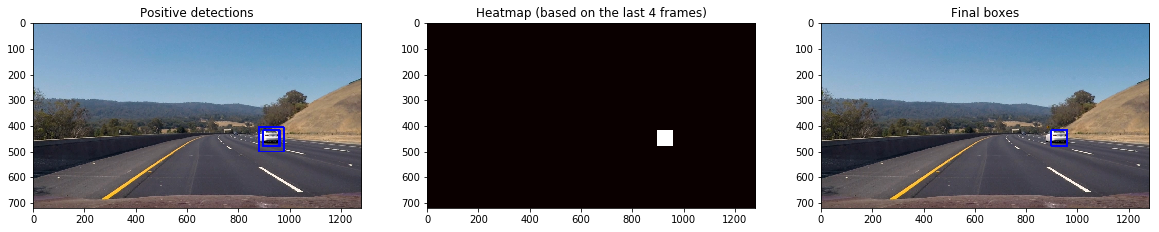

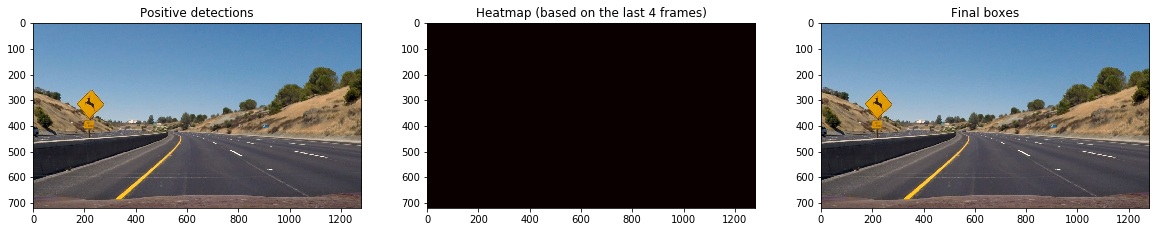

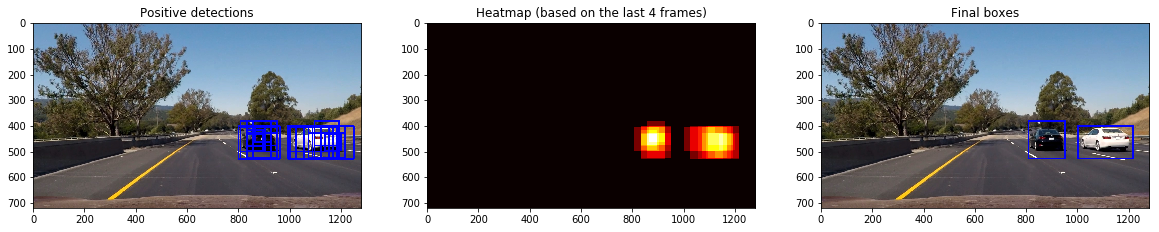

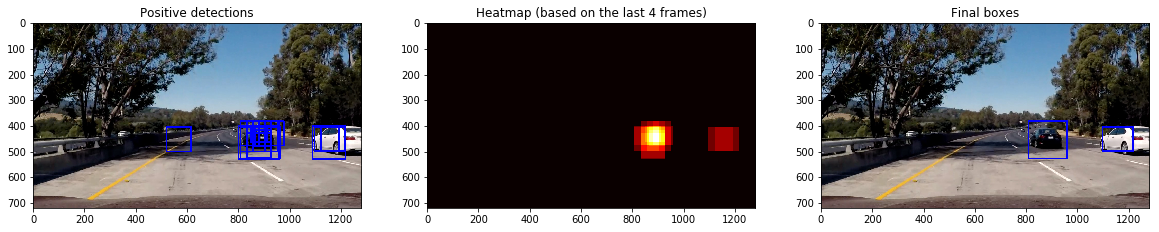

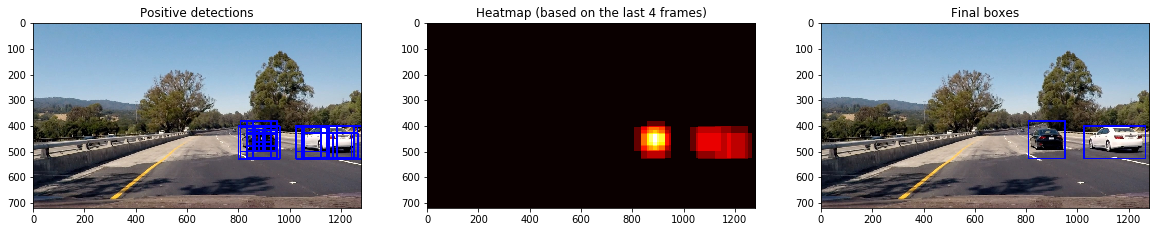

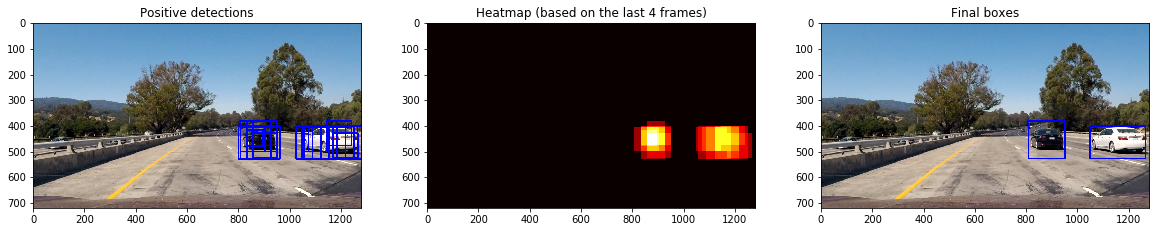

In [9]:
# Load classifier and scaler
# model = pickle.load(open("models/model_linearsvc_11_16.p", "rb"))
model = pickle.load(open("models/model_linearsvc_9_8.p", "rb"))
svc = model["model"]
scaler = model["scaler"]
color_space = model["color_space"]
hog_channel = model["hog_channel"]
hog_orient = model["hog_orient"]
hog_pix_per_cell = model["hog_pix_per_cell"]
hog_cell_per_block = model["hog_cell_per_block"]
spatial_size = model["spatial_size"]
histogram_bins = model["histogram_bins"]

# Read camera image
test_files = glob.glob('test_images/*.jpg')
# test_files = ['test_images/test3.jpg']

# Process files
for file in test_files:
    
    # Load image
    image = mpimg.imread(file)
    
    # Initialize detector
    detector = VehicleDetector(classifier=svc,
                               scaler=scaler,
                               color_space=color_space,
                               hog_channel=hog_channel,
                               hog_orient=hog_orient,
                               hog_pix_per_cell=hog_pix_per_cell,
                               hog_cell_per_block=hog_cell_per_block,
                               spatial_size=spatial_size,
                               histogram_bins=histogram_bins,
                               show_intermediate_results=True)
    
    # Run search
    t0 = time.time()
    labelled_img = detector.search_in_image(image)
    t_detection = time.time() - t0
    print("Time for detection: {:6.4f}s".format(t_detection))
    
    # Show result
    if 0:
        f, ax = plt.subplots(1,1, figsize=(20,10))
        ax.imshow(labelled_img)

## Detect cars in video

In [10]:
from moviepy.editor import VideoFileClip

filename = "test_video.mp4"
filename = "project_video.mp4"
clip = VideoFileClip(filename)
white_output = filename[:-4] + '_output.mp4'

# Initialize detector
detector = VehicleDetector(classifier=svc,
                           scaler=scaler,
                           color_space=color_space,
                           hog_channel=hog_channel,
                           hog_orient=hog_orient,
                           hog_pix_per_cell=hog_pix_per_cell,
                           hog_cell_per_block=hog_cell_per_block,
                           spatial_size=spatial_size,
                           histogram_bins=histogram_bins,
                           show_intermediate_results=False)

white_clip = clip.fl_image(detector.search_in_image)
#white_clip = clip.fl_image(detector.search_in_image).subclip(4, 10)
#white_clip = clip.fl_image(detector.search_in_image).subclip(19, 27)
#white_clip = clip.fl_image(detector.search_in_image).subclip(45, 47)

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [03:16<23:32,  1.27s/it]


 24%|██▍       | 303/1261 [04:59<11:40,  1.37it/s]


 36%|███▌      | 454/1261 [06:46<08:40,  1.55it/s]


 48%|████▊     | 605/1261 [08:33<10:39,  1.03it/s]


 60%|█████▉    | 756/1261 [10:17<06:37,  1.27it/s]


 72%|███████▏  | 907/1261 [12:14<04:19,  1.36it/s]


 84%|████████▍ | 1057/1261 [14:34<03:20,  1.02it/s]


 96%|█████████▌| 1205/1261 [16:32<00:30,  1.81it/s]


100%|█████████▉| 1260/1261 [17:11<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 18min 27s, sys: 7.5 s, total: 18min 35s
Wall time: 17min 11s
